# Preapring for analysis:

## 1. Load the dataset for testing:

In [1]:
import h5py

# Load .mat file
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt


data_path = '/media/volume/sdc/data_cgft/2D_FHIT/Re20kNX1024nx4ny0r0p1/gaussian/test1/NX128/UV.mat'
with h5py.File(data_path, 'r') as f:
    U = torch.tensor(f['U'])
    V = torch.tensor(f['V'])
    U = torch.transpose(U, 1,2)
    V = torch.transpose(V, 1,2)
    print("Shape of U: ", U.shape)
    print("Shape of V: ", V.shape)

data_path = '/media/volume/sdc/data_cgft/2D_FHIT/Re20kNX1024nx4ny0r0p1/gaussian/test1/NX128/S.mat'
with h5py.File(data_path, 'r') as f:
    S1 = torch.tensor(f['S1'])
    S2 = torch.tensor(f['S2'])
    S3 = torch.tensor(f['S3'])
    S1 = torch.transpose(S1, 1,2)
    S2 = torch.transpose(S2, 1,2)
    S3 = torch.transpose(S3, 1,2)
    print("Shape of S1: ", S1.shape)
    print("Shape of S2: ", S2.shape)
    print("Shape of S3: ", S3.shape)

data_path = '/media/volume/sdc/data_cgft/2D_FHIT/Re20kNX1024nx4ny0r0p1/gaussian/test1/NX128/PIvor.mat'
with h5py.File(data_path, 'r') as f:
    PiOmega = torch.tensor(f['PIvor'])
    PiOmega = torch.transpose(PiOmega, 1,2)
    print("Shape of PiOmega: ", PiOmega.shape)

data_path = '/media/volume/sdc/data_cgft/2D_FHIT/Re20kNX1024nx4ny0r0p1/gaussian/test1/NX128/PsiVor.mat'
with h5py.File(data_path, 'r') as f:
    Psi = torch.tensor(f['Psi'])
    Omega = torch.tensor(f['Vor'])
    Psi = torch.transpose(Psi, 1,2)
    Omega = torch.transpose(Omega, 1,2)
    print("Shape of Psi: ", Psi.shape)
    print("Shape of Omega: ", Omega.shape)


/home/exouser/anaconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_524437/3420595801.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/torch/csrc/utils/tensor_new.cpp:230.)
  U = torch.tensor(f['U'])


Shape of U:  torch.Size([400, 128, 128])
Shape of V:  torch.Size([400, 128, 128])
Shape of S1:  torch.Size([400, 128, 128])
Shape of S2:  torch.Size([400, 128, 128])
Shape of S3:  torch.Size([400, 128, 128])
Shape of PiOmega:  torch.Size([400, 128, 128])
Shape of Psi:  torch.Size([400, 128, 128])
Shape of Omega:  torch.Size([400, 128, 128])


## 2. Initialize wavenumbers and grids

/home/exouser/anaconda3/envs/torch_gpu/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


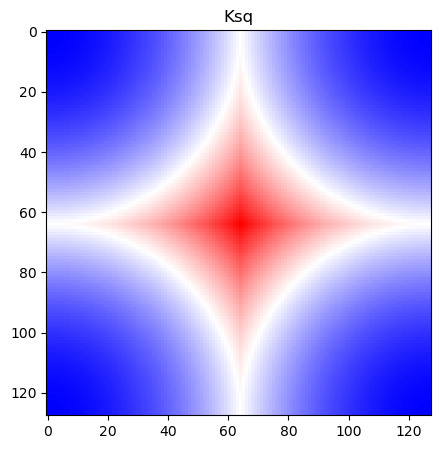

In [2]:
from utils.convert import initialize_wavenumbers_2DFHIT
import numpy as np
Nx = 128
Ny = 128
L = 2*torch.pi
Kx, Ky, Ksq = initialize_wavenumbers_2DFHIT(Nx, Ny, L, L)

# Plot the Kx and Ky grid
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(Ksq, cmap='bwr')
ax.set_title('Ksq')
plt.show()




# Radially average spectrum


In [3]:
import torch

def spectrum_radially_averaged_2DFHIT(A, spectral=False):
    #################################################################################################################################################
    # -------------------------------------------------------- Notes for using this function: --------------------------------------------------------
    # Validated with Karan's spectrum code
    
    # One thing need to be checked in this function is that it gives out Nx/2 + 1 wavenumbers, but it should give us Nx/2 wavenumbers. 
    
    # Last wavenumber is extra, so it should be removed for now. In the future, based 
    
    # Also the averaging is not correct. The correct way to do it is that for even size of matrices, we need to first form the symmetric version by putttng
    # the first column and first row at the end of the matrix with proper flipping and conjugating. Then we can do the averaging with this way.
    #################################################################################################################################################
    """
    Compute the radially/angle-averaged spectrum of a 2D square matrix.

    Parameters
    ----------
    A : torch.Tensor
        The input 2D square matrix. If `spectral` is False, `A` is in the physical domain; otherwise, it is in the spectral domain.
    spectral : bool, optional
        Whether `A` is in the spectral domain. Default is False.

    Returns
    -------
    spectrum : torch.Tensor
        The radially/angle-averaged spectrum of `A`.
    wavenumbers : torch.Tensor
        The corresponding wavenumbers.
    """

    # Check if A is a 2D square tensor
    if not isinstance(A, torch.Tensor) or A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('Input is not a 2D square matrix. Please input a 2D square matrix')

    # Check if `spectral` is a boolean
    if not isinstance(spectral, bool):
        raise ValueError('Invalid input for spectral. It should be a boolean value')

    nx = A.shape[0]
    L = 2 * torch.pi
    kx = 2 * torch.pi * torch.fft.fftfreq(nx, d=L/nx)
    ky = 2 * torch.pi * torch.fft.fftfreq(nx, d=L/nx)
    wavenumber_x, wavenumber_y = torch.meshgrid(kx, ky)
    absolute_wavenumber = torch.sqrt(wavenumber_x ** 2 + wavenumber_y ** 2)
    absolute_wavenumber = torch.fft.fftshift(absolute_wavenumber)

    if not spectral:
        spectral_A = torch.fft.fft2(A)
    else:
        spectral_A = A

    spectral_A = torch.abs(spectral_A) / (nx ** 2)
    spectral_A = torch.fft.fftshift(spectral_A)

    # As of my knowledge cutoff (Sept 2021), there is no PyTorch built-in function similar to numpy's `digitize`
    # So we will use numpy here and then convert the result back to a torch tensor
    bin_edges = torch.arange(-0.5, nx / 2 + 0.5)
    binnumber = torch.from_numpy(np.digitize(absolute_wavenumber.flatten().numpy(), bins=bin_edges.numpy()))
    spectrum = torch.bincount(binnumber, weights=spectral_A.flatten())[1:]
    wavenumbers = torch.arange(0, nx // 2 + 1)

    return spectrum, wavenumbers


# Pearson Correlation Coefficient (CC):
### https://www.mathworks.com/help/images/ref/corr2.html

In [4]:
import torch

def corr2(x, y, batch_mode=False):
    """
    Calculate the mean correlation coefficient between single or batches of input data.
    
    Parameters
    ----------
    x, y : torch.Tensor
        Input tensors with the same number of matrices and the same batch size if batch_mode is True 
        (dimensions should be (N, H, W) or (N, 1, H, W) for single and batch input).
    batch_mode : bool, optional
        Set True to calculate the correlation coefficient for batches of input data, by default False.
        
    Returns
    -------
    mean_corr_coeffs : float or torch.Tensor
        Mean correlation coefficient between the matrices in x and y for single input (float) 
        or mean correlation coefficients for each batch if batch_mode is True (torch.Tensor with shape: (B,)).
    """
    if not (isinstance(x, torch.Tensor) and isinstance(y, torch.Tensor)):
        raise ValueError("Both input tensors must be torch.Tensor objects.")
    
    if x.shape != y.shape:
        raise ValueError("Both input tensors must have the same dimensions.")
    
    # Remove singleton dimensions, if present
    x = torch.squeeze(x, dim=-3) if len(x.shape) == 4 else x
    y = torch.squeeze(y, dim=-3) if len(y.shape) == 4 else y

    if batch_mode:
        batch_size = x.shape[0]
        mean_corr_coeffs = torch.empty(batch_size, dtype=torch.float32)

        for batch_idx in range(batch_size):
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]
            mean_corr_coeffs[batch_idx] = corr2(x_batch, y_batch)

        return mean_corr_coeffs

    else:
        x_mean_centered = x - x.mean(dim=(-2, -1)).reshape(-1, 1, 1)
        y_mean_centered = y - y.mean(dim=(-2, -1)).reshape(-1, 1, 1)

        r = (x_mean_centered * y_mean_centered).sum(dim=(-2, -1)) / torch.sqrt((x_mean_centered**2).sum(dim=(-2, -1)) * (y_mean_centered**2).sum(dim=(-2, -1)))
        mean_corr_coeff = r.mean().item()

        return mean_corr_coeff


# Test for corr2:
## Facts about CC:
### CC is validated with corr2 of matlab.
### CC doesn't change with any scaling or normalization or standardization


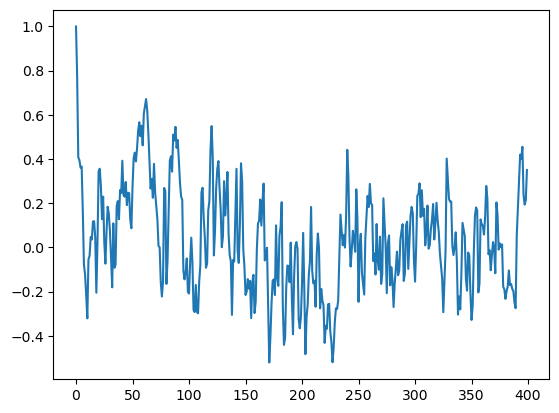

In [5]:
cc = torch.zeros(400)
for i in range(400):
    cc[i]= corr2(U[0], U[i])

# Plot CC vs. time
plt.plot(cc)

# Energy Transfer:

The function is capable of calculating Energy Transfer in physical space using 
Inputs: UV or Psi
Outputs: PiOmega or Tau

For the combinmation of (UV --> PiOmega), function cannot calculate the Ptau

In [26]:

from utils.derivative_2D_FHIT import derivative_2D_FHIT

def energy_transfer_2DFHIT(input='UV', output='Tau', U=None, V=None, Tau11=None, Tau12=None, Tau22=None, Psi=None, PiOmega=None, Kx=None, Ky=None, Ksq=None):
    """
    Calculates energy transfer of 2D_FHIT using SGS stress or PiOmega.

    Parameters:
    input (str): Type of the input data ('UV' or 'Psi')
    output (str): Type of the output data ('PiOmega' or 'Tau')
    U, V (np.array): Velocities
    Tau11, Tau12, Tau22 (np.array): SGS stress
    Psi, PiOmega (np.array): variables for PiOmega calculation
    Kx, Ky, Ksq (np.array): spectral wavenumber components
    
    Returns:
    PTau (np.array): Energy transfer
    """
    if input == 'UV' and output == 'Tau':
        Ux = derivative_2D_FHIT(U, [1, 0], Kx, Ky, spectral=False)
        Uy = derivative_2D_FHIT(U, [0, 1], Kx, Ky, spectral=False)
        Vx = derivative_2D_FHIT(V, [1, 0], Kx, Ky, spectral=False)
        PTau = -(Tau11 - Tau22) * Ux - Tau12 * (Uy + Vx)
        return PTau


    elif input == 'Psi' and output == 'PiOmega':
        PTau = - Psi * PiOmega
        return PTau

    else:
        print("Invalid input or output type. Acceptable combinations are: UV-->Tau, Psi-->PiOmega")
        return None


The contour plot of the error: 


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


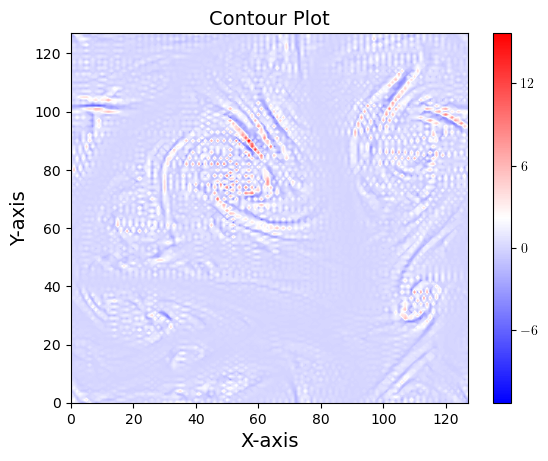

The correlation coefficient between Ptau from UV/Tau and Psi/PiOmega: 


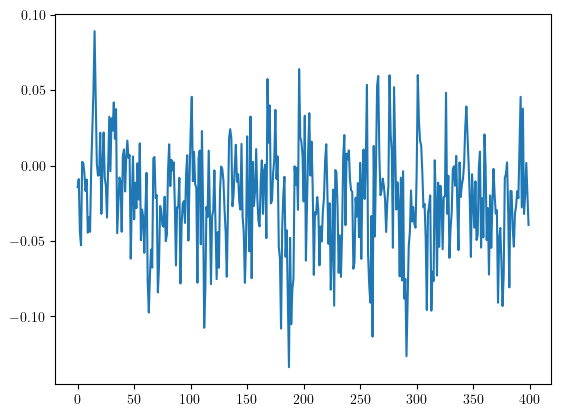

In [27]:
from utils.create_contour_plot import create_contour_plot
# Validate Ptau from UV/Tau and Psi/PiOmega

Ptau_UV_Tau = torch.zeros(400, 128, 128)
Ptau_Psi_PiOmega = torch.zeros(400, 128, 128)
cc_Ptau = torch.zeros(400)
for i in range(400):
    Ptau_UV_Tau[i] = energy_transfer_2DFHIT(input='UV', output='Tau', U=U[i], V=V[i], Tau11=S1[i], Tau12=S2[i], Tau22=S3[i], Kx=Kx, Ky=Ky, Ksq=Ksq)
    Ptau_Psi_PiOmega[i] = energy_transfer_2DFHIT(input='Psi', output='PiOmega', Psi=Psi[i], PiOmega=PiOmega[i], Kx=Kx, Ky=Ky, Ksq=Ksq)
    cc_Ptau[i] = corr2(Ptau_UV_Tau[i], Ptau_Psi_PiOmega[i])

print("The contour plot of the error: ")
create_contour_plot(Ptau_UV_Tau[0]-Ptau_Psi_PiOmega[0])

print("The correlation coefficient between Ptau from UV/Tau and Psi/PiOmega: ")
plt.plot(cc_Ptau)

# Validating the Tau2PiOmega function: 
## Status: the spectrum of PiOmega data and converted PiOmega from Tau has been validated

Spectra of PiOmega from Tau and real PiOmega:


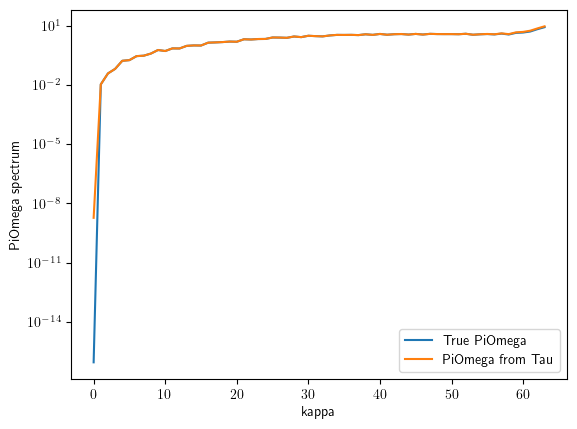

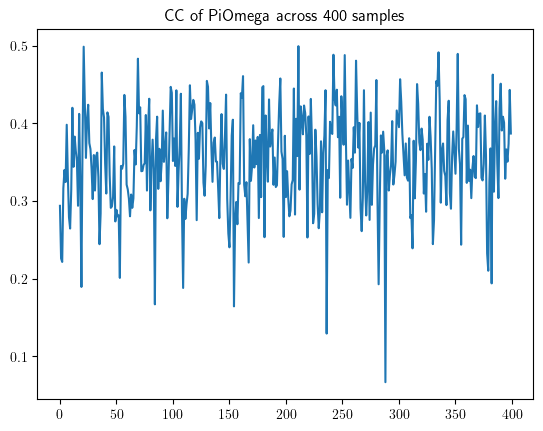

Mean(std) of CC across 400 samples:   tensor(0.3542) ( tensor(0.0632) )
Contour plot of PiOmega from Tau: 


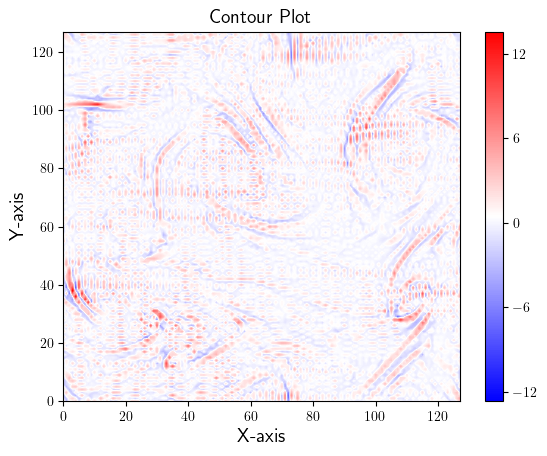

Contour plot of PiOmega Data: 


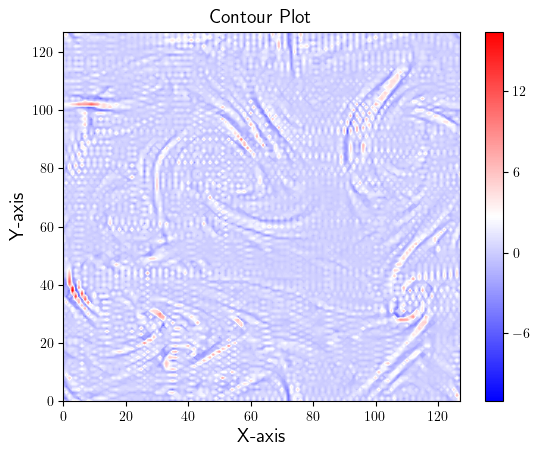

Contour plot of the error: 


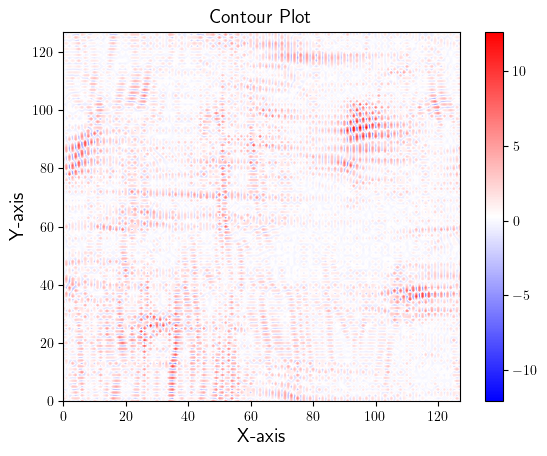

In [28]:
from utils.create_contour_plot import create_contour_plot
from utils.convert import Tau2PiOmega_2DFHIT, spectrum_angled_average_2DFHIT

# Check Tau2PiOmega_2DFHIT function
import torch

PiOmega_func = torch.zeros((400, 128, 128))
PiOmega_func_spec = np.zeros((400, 65))
PiOmega_spec = np.zeros((400, 65))
for i in range(400):

    PiOmega_func[i] = Tau2PiOmega_2DFHIT(S1[i], S2[i], S3[i], Kx, Ky, Ksq, spectral=False)
    PiOmega_func_spec[i], kappa = spectrum_radially_averaged_2DFHIT(PiOmega_func[i], spectral=False)
    PiOmega_spec[i], kappa = spectrum_radially_averaged_2DFHIT(PiOmega[i], spectral=False)

# Plot PiOmega spectrum vs. real PiOmega spectrum
print("Spectra of PiOmega from Tau and real PiOmega:")
plt.plot(kappa[:-1], PiOmega_spec.mean(axis=0).T[:-1], label='True PiOmega')
plt.plot(kappa[:-1], PiOmega_func_spec.mean(axis=0).T[:-1], label='PiOmega from Tau')
plt.legend()
plt.xlabel('kappa')
plt.ylabel('PiOmega spectrum')
plt.yscale('log')
plt.show()

# Checking the CC across different time steps
cc_PiOmega = torch.zeros(400)
for i in range(400):
    cc_PiOmega[i]= corr2(PiOmega_func[i], PiOmega[i])

plt.plot(cc_PiOmega)
plt.title("CC of PiOmega across 400 samples")
plt.show()

print("Mean(std) of CC across 400 samples:  ", cc_PiOmega.mean(), "(", cc_PiOmega.std(), ")")

print("Contour plot of PiOmega from Tau: ")
create_contour_plot(PiOmega_func[0])
print("Contour plot of PiOmega Data: ")
create_contour_plot(PiOmega[0])
error = PiOmega_func[0] - PiOmega[0].numpy()
print("Contour plot of the error: ")
create_contour_plot(error)


In [29]:
Ptau_UV_Tau = torch.zeros(400, 128, 128)
Ptau_Psi_Tau = torch.zeros(400, 128, 128)
Ptau_Psi_PiOmega = torch.zeros(400, 128, 128)

Ptau_UV_Tau_spec_list = []
Ptau_Psi_PiOmega_spec_list = []
Ptau_Psi_Tau_spec_list = []

for i in range(400):
    Ptau_UV_Tau_slice = energy_transfer_2DFHIT(input='UV', output='Tau', U=U[i].numpy(), V=V[i].numpy(), Tau11=S1[i].numpy(), Tau12=S2[i].numpy(), Tau22=S3[i].numpy(), Kx=Kx, Ky=Ky, Ksq=Ksq)
    Ptau_Psi_PiOmega_slice = energy_transfer_2DFHIT(input='Psi', output='PiOmega', Psi=Psi[i].numpy(), PiOmega=Omega[i].numpy(), Kx=Kx, Ky=Ky, Ksq=Ksq)
    Ptau_Psi_Tau_slice = energy_transfer_2DFHIT(input='Psi', output='Tau', Psi=Psi[i], Tau11=S1[i], Tau12=S2[i], Tau22=S3[i], Kx=Kx, Ky=Ky, Ksq=Ksq)

    np_Ptau_UV_Tau_spec, kappa = spectrum_angled_average_2DFHIT(Ptau_UV_Tau_slice, spectral=False)
    np_Ptau_Psi_PiOmega_spec, kappa = spectrum_angled_average_2DFHIT(Ptau_Psi_PiOmega_slice, spectral=False)
    np_Ptau_Psi_Tau_spec, kappa = spectrum_angled_average_2DFHIT(Ptau_Psi_Tau_slice.numpy(), spectral=False)

    Ptau_UV_Tau_spec_list.append(torch.from_numpy(np_Ptau_UV_Tau_spec))
    Ptau_Psi_PiOmega_spec_list.append(torch.from_numpy(np_Ptau_Psi_PiOmega_spec))
    Ptau_Psi_Tau_spec_list.append(torch.from_numpy(np_Ptau_Psi_Tau_spec))

    Ptau_UV_Tau[i] = torch.from_numpy(Ptau_UV_Tau_slice)
    Ptau_Psi_PiOmega[i] = torch.from_numpy(Ptau_Psi_PiOmega_slice)
    Ptau_Psi_Tau[i] = Ptau_Psi_Tau_slice


# Convert lists to tensors
Ptau_UV_Tau_spec = torch.stack(Ptau_UV_Tau_spec_list)
Ptau_Psi_PiOmega_spec = torch.stack(Ptau_Psi_PiOmega_spec_list)
Ptau_Psi_Tau_spec = torch.stack(Ptau_Psi_Tau_spec_list)

print(Ptau_UV_Tau_spec.shape)
print(Ptau_Psi_PiOmega_spec.shape)
print(Ptau_Psi_Tau_spec.shape)

# Plotting energy transfer from differnet input/output pairs
index = 0
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].contourf(Ptau_UV_Tau[0], cmap='bwr')
ax[0].set_title('UV --> Tau')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].contourf(Ptau_Psi_Tau[0], cmap='bwr')
ax[1].set_title('Psi --> Tau')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

ax[2].contourf(Ptau_Psi_PiOmega[0], cmap='bwr')
ax[2].set_title('Psi --> PiOmega')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

plt.show()


# Calculate the correlation coefficient between energy transfer from different input/output pairs

# UV --> Tau

cc_UV_Tau = torch.zeros(400)
cc_Psi_Tau = torch.zeros(400)
cc_Psi_PiOmega = torch.zeros(400)
for i in range(400):
    cc_UV_Tau[i]= corr2(Ptau_UV_Tau[0], Ptau_UV_Tau[i])
    cc_Psi_Tau[i]= corr2(Ptau_Psi_Tau[0], Ptau_Psi_Tau[i])
    cc_Psi_PiOmega[i]= corr2(Ptau_Psi_PiOmega[0], Ptau_Psi_PiOmega[i])

# Plot CC vs. time

plt.plot(cc_UV_Tau, label='UV --> Tau')
plt.plot(cc_Psi_Tau, label='Psi --> Tau')
plt.plot(cc_Psi_PiOmega, label='Psi --> PiOmega')
plt.legend()
plt.show()

# Plot the spectrums on the same plot
plt.plot(kappa[1:-1], Ptau_UV_Tau_spec.mean(axis=0).T[1:-1], label='UV --> Tau')

plt.plot(kappa[1:-1], Ptau_Psi_PiOmega_spec.mean(axis=0).T[1:-1], label='Psi --> PiOmega')
plt.plot(kappa[1:-1], Ptau_Psi_Tau_spec.mean(axis=0).T[1:-1], label='Psi --> Tau')
plt.legend()
plt.xlabel('kappa')
plt.ylabel('Ptau')

# Log scale
plt.yscale('log')

plt.show()




TypeError: fft_fft2(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

Validating Spectrum anlge average in torch:

# Energy Transfer Spectra

### Defintion from UV to TAU : 

In [30]:
from utils.derivative_2D_FHIT import derivative_2D_FHIT
def energyTransfer_spectra_2DFHIT(U, V, Tau11, Tau12, Tau22, Kx, Ky, input_space='physical'):
    #################################################################################################################################################
    # -------------------------------------------------------- Notes for using this function: -------------------------------------------------------
    # It should be suitable for both UV/TAU and PSI/PIOMEGA: Now it is just for UV --> TAU
    # 

    #################################################################################################################################################
    
     
    N_LES = U.shape[0] 

    Ux = derivative_2D_FHIT(U, [1,0], Kx, Ky, spectral=False)
    Uy = derivative_2D_FHIT(U, [0,1], Kx, Ky, spectral=False)
    Vx = derivative_2D_FHIT(V, [1,0], Kx, Ky, spectral=False)

    if input_space == 'physical':
        Tau11_hat = torch.fft.fft2(Tau11)
        Tau12_hat = torch.fft.fft2(Tau12)
        Tau22_hat = torch.fft.fft2(Tau22)
        U1x_hat = torch.fft.fft2(Ux)
        U1y_hat = torch.fft.fft2(Uy)
        V1x_hat = torch.fft.fft2(Vx)

    Ptau_hat = -torch.real((-Tau11_hat.conj() * U1x_hat + Tau22_hat.conj() * U1x_hat - Tau12_hat.conj() * U1y_hat - Tau12_hat.conj() * V1x_hat)) / (N_LES * N_LES)

    # Ptau_hat = -torch.real(torch.conj(PiOmega_hat) * Psi_hat) / (N_LES * N_LES)

    spectra, wavenumber = spectrum_radially_averaged_2DFHIT(Ptau_hat, spectral=True)

    return spectra, wavenumber


### Definition from Psi to PiOmega

In [31]:
def energyTransfer_spectra_2DFHIT_PsiPiOmega(Psi, PiOmega, input_space='physical'):
    N_LES = Psi.shape[0] 

    if input_space == 'physical':
        Psi_hat = torch.fft.fft2(Psi)
        PiOmega_hat = torch.fft.fft2(PiOmega)


    Ptau_hat = -torch.real(torch.conj(PiOmega_hat) * Psi_hat) / (N_LES * N_LES)

    spectra, wavenumber = spectrum_radially_averaged_2DFHIT(Ptau_hat, spectral=True)

    return spectra, wavenumber


## Cross checking Energy Transfer in Physical Domain with two different inputs/outputs: UV/TAU and Psi/PiOmega

The spectra of Ptau from UV Tau and Psi PiOmega are plotted on the same plot


Text(0.5, 0, 'kappa')

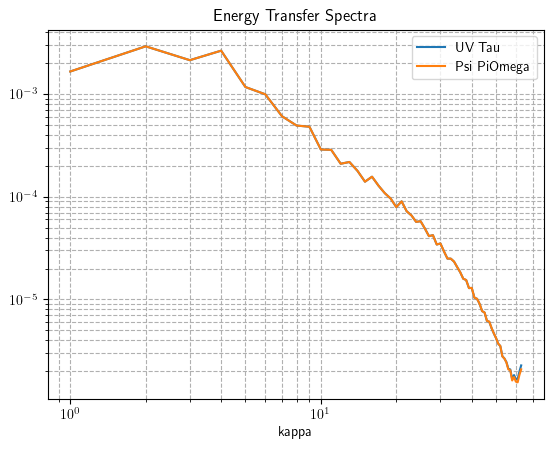

In [32]:

Ptau_spec_UVTau = torch.zeros(400, 65)
Ptau_spec_PiOmega = torch.zeros(400, 65)
for i in range(400):
    Ptau_spec_UVTau[i], kappa = energyTransfer_spectra_2DFHIT(U[i], V[i], S1[i], S2[i], S3[i], Kx, Ky, input_space='physical')
    Ptau_spec_PiOmega[i], kappa = energyTransfer_spectra_2DFHIT_PsiPiOmega(Psi[i], PiOmega[i], input_space='physical')

# Plot the spectrums on the same plot
print("The spectra of Ptau from UV Tau and Psi PiOmega are plotted on the same plot") 
plt.loglog(kappa[1:-1], Ptau_spec_UVTau.mean(axis=0).T[1:-1], label='UV  Tau')
plt.loglog(kappa[1:-1], Ptau_spec_PiOmega.mean(axis=0).T[1:-1], label='Psi  PiOmega')
plt.title('Energy Transfer Spectra')
# Grid on
plt.grid(True, which="both", ls="--")
plt.legend()
plt.xlabel('kappa')

## Enstrophy Transfer Spectra

### Definition from Omega to PiOmega
#### The current problem is that the code only gives postive values for the Enstrophy transfer Spectra. still seeking for the reason. Possible reasons: 1. Checking derivative function, 2. checking spectrum code

In [10]:
from utils.derivative_2D_FHIT import derivative_2D_FHIT

# def enstrophyTransfer_spectra_2DFHIT(Omega, Sigma1, Sigma2, Kx, Ky, input_space='physical'):
    
#     N_LES = Omega.shape[0] 

#     Omegax = derivative_2D_FHIT(Omega, [1,0], Kx, Ky, spectral=False)
#     Omegay = derivative_2D_FHIT(Omega, [0,1], Kx, Ky, spectral=False)

#     if input_space == 'physical':
#         Omegax_hat = torch.fft.fft2(Omegax)
#         Omegay_hat = torch.fft.fft2(Omegay)
#         Sigma1_hat = torch.fft.fft2(Sigma1)
#         Sigma2_hat = torch.fft.fft2(Sigma2)

#     Pz_hat = -(Sigma1_hat.conj() * Omegax_hat + Sigma2_hat.conj() * Omegay_hat).real / (N_LES * N_LES)

#     spectra, wavenumber = spectrum_radially_averaged_2DFHIT(Pz_hat, spectral=True)

#     return spectra, wavenumber

def enstrophyTransfer_spectra_2DFHIT(Omega, PiOmega, Kx, Ky, input_space='physical'):
    
    N_LES = Omega.shape[0] 

    if input_space == 'physical':
        Omega_hat = torch.fft.fft2(Omega)
        PiOmega_hat = torch.fft.fft2(PiOmega)

    Pz_hat = -torch.real((PiOmega_hat.conj() * Omega_hat)) / (N_LES * N_LES)

    spectra, wavenumber = spectrum_radially_averaged_2DFHIT(Pz_hat, spectral=True)

    return spectra, wavenumber

Text(0.5, 0, 'kappa')

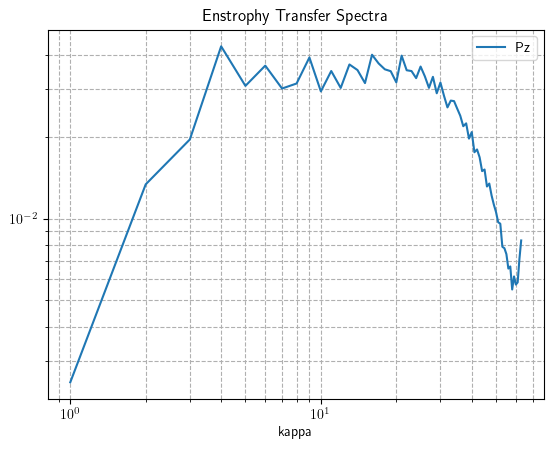

In [33]:
# Trting random data as input and output: 
# U = torch.randn(400, 128, 128)
# V = torch.randn(400, 128, 128)
# S1 = torch.randn(400, 128, 128)
# S2 = torch.randn(400, 128, 128)
# S3 = torch.randn(400, 128, 128)
# Psi = torch.randn(400, 128, 128)
# PiOmega = torch.randn(400, 128, 128)
# Omega = torch.randn(400, 128, 128)
Pz_spec = torch.zeros(400, 65)
for i in range(400):
    Pz_spec[i], kappa = enstrophyTransfer_spectra_2DFHIT(Omega[i], PiOmega[i], Kx, Ky, input_space='physical')


plt.loglog(kappa[1:-1], Pz_spec.mean(axis=0).T[1:-1], label='Pz')
plt.title('Enstrophy Transfer Spectra')
# Grid on
plt.grid(True, which="both", ls="--")
plt.legend()
plt.xlabel('kappa')



## One direction spectrum: 

In [75]:
import torch
import matplotlib.pyplot as plt

def spectrum_xy_averaged_2D(A, direction, spectral=False):
    Nx = A.shape[0]
    Ny = A.shape[1]

    # Generating wavenumbers
    L = 2 * torch.pi
    kx = 2 * torch.pi * torch.fft.fftfreq(Nx, d=L/Nx)
    ky = 2 * torch.pi * torch.fft.fftfreq(Ny, d=L/Ny)
    wavenumber_x, wavenumber_y = torch.meshgrid(kx, ky)

    if spectral:
        A_hat = A
    else:
        A_hat = torch.fft.fft2(A)

    # Taking abs and fftshift
    A_hat = torch.abs(A_hat)
    A_hat = torch.fft.fftshift(A_hat)

    if direction[0] == 1 and direction[1] == 0:
        A_hat_mean = A_hat.mean(axis=1)
        # A_spec = torch.flip(A_hat_mean[:Ny//2]/Ny, [0])
        A_spec = torch.flip(A_hat_mean[:Ny//2], [0])
        print(A_hat_mean[:Ny//2].shape)
        wavenumbers = torch.arange(0, Nx // 2)
    elif direction[0] == 0 and direction[1] == 1:
        A_hat_mean = A_hat.mean(axis=0)
        # A_spec = torch.flip(A_hat_mean[:Nx//2]/Nx, [0])
        A_spec = torch.flip(A_hat_mean[:Nx//2], [0])
        wavenumbers = torch.arange(0, Ny // 2)
    else:
        raise ValueError('Direction must be [1,0] or [0,1]')
    
    return A_spec, wavenumbers

## Validation:
### The spectrum of Uy and Vx are on top of each other. 
### One point that needs to be checked is that, whether I need to divide the spectrum by NX when I do the averaging.

torch.Size([64])


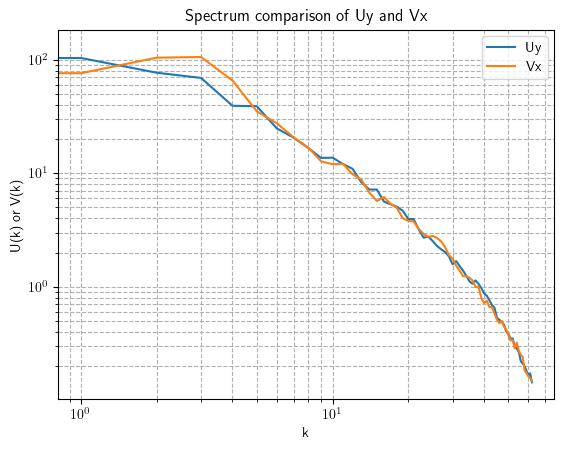

In [83]:
# Use the function like this:
A_spec_uy, wavenumbers = spectrum_xy_averaged_2D(U[0], [0,1], spectral=False)
A_spec_vx, wavenumbers = spectrum_xy_averaged_2D(V[0], [1,0], spectral=False)


plt.loglog(wavenumbers[:-1], A_spec_uy[:-1], label='Uy')
plt.loglog(wavenumbers[:-1], A_spec_vx[:-1], label='Vx')
plt.title('Spectrum comparison of Uy and Vx')
plt.grid(True, which="both", ls="--")
plt.xlabel('k')
plt.ylabel('U(k) or V(k)')
plt.legend()
plt.show()